# PySpark-based CORD-19 Recommendation Engine

## Contents

1. [Introduction](#Introduction)

2. [Apache Spark](#Apache-Spark)

3. [Dataset](#Dataset)

4. [Topic Modelling](#Topic-Modelling)

5. [Paper Recommendation](#Paper-Recommendation)

6. [Interactive Widgets](#Interactive-Widgets)

7. [Conclusion](#Conclusion)

8. [Reference](#Reference)

----------------------------
## Introduction

Given the huge volume of research articles and the ongoing spread of COVID-19 in the global, it posts a difficult task for the frontline health professionals to keep up with the latest update in the research community. They need efficient tools to explore and browse large collections of scholarly literature. When you find an interesting research paper, can we utilise advanced clustering algorithms to speed up the process when trying to find similar literature without browsing a large pool of existing publications? Or if we have a question or task in mind, can we feed it into the algorithms to find out relevant articles? To develop the necessary tools for exploring and browsing a large collection of literatures, we require automated methods of organising, managing, and delivering these contents.

In this project, topic modelling would be implemented for clustering similar research articles. Topic modelling allows us to represent each article as a mixture of topics. By mapping each article into the topic space, we can find related articles. Moreover, to accelerate the speed of large-scale processing for the CORD-19 dataset, we perform the analysis using Apache Spark with its Python API in a Jupyter Notebook.

----------------------
## Apache Spark

Spark allows us to build scalable machine learning (ML) pipeline containing Latent Dirichlet Allocation (LDA) from its machine learning library (MLlib). Another benefit of a data product can be easily translated to a production environment.


In [1]:
import builtins as p
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.types import *
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import monotonically_increasing_id

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import datetime
import string
import numpy as np 
import pandas as pd
import joblib
from matplotlib import pyplot
import numpy


from IPython.display import HTML, display, clear_output
from ipywidgets import interact, Layout, HBox, VBox, Box, widgets

from tqdm import tqdm
from os.path import isfile
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer()

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

-----------------------
## Dataset

The dataset is maintained at [https://www.semanticscholar.org/cord19)

In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dateset (CORD-19). CORD-19 is a open research dataset that contains more than 280,000 scholarly articles about the novel coronavirus for use by the global research community, which is intended to mobilize researchers to apply recent advances in NLP to generate new insights in support of the fight against the infectious disease.

### Loading the Data

Loading the cleaned 'cord.csv' in dataframe, where the code for outputting the 'cord.csv' could be found on get_clean_cord19.py.

In [2]:
df = spark.read.csv("gs://st446-project/cord.csv",header=True)

In [3]:
# Checking the Schema of the dataframe
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- cord_uid: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- url: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- introduction: string (nullable = true)
 |-- year: string (nullable = true)



In [4]:
df.show()
print('Total number of rows: ', df.count())

+---+--------+--------------------+------------+--------------------+--------------------+--------------------+----+
|_c0|cord_uid|               title|publish_time|                 url|            abstract|        introduction|year|
+---+--------+--------------------+------------+--------------------+--------------------+--------------------+----+
|  0|ug7v899j|Clinical features...|  2001-07-04|https://www.ncbi....|OBJECTIVE: This r...|Mycoplasma pneumo...|2001|
|  1|02tnwd4m|Nitric oxide: a p...|  2000-08-15|https://www.ncbi....|Inflammatory dise...|Since its discove...|2000|
|  2|ejv2xln0|Surfactant protei...|  2000-08-25|https://www.ncbi....|Surfactant protei...|Surfactant protei...|2000|
|  3|2b73a28n|Role of endotheli...|  2001-02-22|https://www.ncbi....|Endothelin-1 (ET-...|                null|2001|
|  4|9785vg6d|Gene expression i...|  2001-05-11|https://www.ncbi....|Respiratory syncy...|RSV and PVM are v...|2001|
|  5|zjufx4fo|Sequence requirem...|  2001-12-17|http://europepmc

In [5]:
def only_covid_19(df):
    """
    param
    df: dataframe
    return RDD that the introduction of each research paper contains the string 'COVID-19'
    """
    return df.filter(df.introduction.contains('COVID-19'))

only_covid_19(df).show()
print("Total number of rows that the introduction of each research paper contains the string 'COVID-19': ", only_covid_19(df).count())

+-----+--------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+
|  _c0|cord_uid|               title|publish_time|                 url|            abstract|        introduction|                year|
+-----+--------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+
|11614|yv4x8viu|Extracorporeal Li...|  2020-05-12|https://www.ncbi....|The Extracorporea...|The World Health ...|                2020|
|11621|ii3a6ne7|The Time Sequence...|  2020-05-16|https://www.ncbi....|                null|Recent studies fo...|                2020|
|11625|d4pswmxa|Impact of the Cor...|  2020-05-16|https://www.ncbi....|OBJECTIVE: The co...|In a short time, ...|                2020|
|12067|3mvzkff6|Oxone(®)-Mediated...|  2020-06-15|https://www.ncbi....|Recent exploratio...|According to the ...|                2020|
|12162|02am7l4t|Histopathological...|  2020-06-10|https

In [6]:
def relevant_time(df, lower, upper):
    """
    param
    df: dataframe
    lower: the lower bound of the date
    upper: the upper bound of the date
    return RDD that between the specific lower bound and upper bound of the date 
    """
    return df.filter(df.year.between(lower, upper))

relevant_time(df, 2000, 2021).show()
print("Total number of rows that between 2000 and 2021: ", relevant_time(df, 2000, 2021).count())

+---+--------+--------------------+------------+--------------------+--------------------+--------------------+----+
|_c0|cord_uid|               title|publish_time|                 url|            abstract|        introduction|year|
+---+--------+--------------------+------------+--------------------+--------------------+--------------------+----+
|  0|ug7v899j|Clinical features...|  2001-07-04|https://www.ncbi....|OBJECTIVE: This r...|Mycoplasma pneumo...|2001|
|  1|02tnwd4m|Nitric oxide: a p...|  2000-08-15|https://www.ncbi....|Inflammatory dise...|Since its discove...|2000|
|  2|ejv2xln0|Surfactant protei...|  2000-08-25|https://www.ncbi....|Surfactant protei...|Surfactant protei...|2000|
|  3|2b73a28n|Role of endotheli...|  2001-02-22|https://www.ncbi....|Endothelin-1 (ET-...|                null|2001|
|  4|9785vg6d|Gene expression i...|  2001-05-11|https://www.ncbi....|Respiratory syncy...|RSV and PVM are v...|2001|
|  5|zjufx4fo|Sequence requirem...|  2001-12-17|http://europepmc

In [7]:
def only_covid_19_and_relevant_time(df, lower, upper):
    """
    param
    df: dataframe
    lower: the lower bound of the date
    upper: the upper bound of the date
    return RDD that the introduction of each research paper contains the string 'COVID-19'
    and between the specific lower bound and upper bound of the date 
    """
    return df.filter(df.introduction.contains('COVID-19') & df.year.between(lower, upper))

only_covid_19_and_relevant_time(df, 2020, 2021).show()
print("Total number of rows that between 2000 and 2021, and the introduction of each research paper contains the string 'COVID-19': ", only_covid_19_and_relevant_time(df, 2020, 2021).count())

+-----+--------+--------------------+------------+--------------------+--------------------+--------------------+----+
|  _c0|cord_uid|               title|publish_time|                 url|            abstract|        introduction|year|
+-----+--------+--------------------+------------+--------------------+--------------------+--------------------+----+
|11614|yv4x8viu|Extracorporeal Li...|  2020-05-12|https://www.ncbi....|The Extracorporea...|The World Health ...|2020|
|11621|ii3a6ne7|The Time Sequence...|  2020-05-16|https://www.ncbi....|                null|Recent studies fo...|2020|
|11625|d4pswmxa|Impact of the Cor...|  2020-05-16|https://www.ncbi....|OBJECTIVE: The co...|In a short time, ...|2020|
|12067|3mvzkff6|Oxone(®)-Mediated...|  2020-06-15|https://www.ncbi....|Recent exploratio...|According to the ...|2020|
|12162|02am7l4t|Histopathological...|  2020-06-10|https://www.ncbi....|Skin manifestatio...|In the initial an...|2020|
|12195|6lr1nxj7|The Effects of Ta...|  2020-06-3

In [8]:
def specific_topic(df, topic_num):
    """
    param
    df: dataframe
    topic_num: topic number 
    return dataframe that contains the specific dominant topic
    """
    return df.filter(df['topic'] == topic_num)

In [9]:
# Drop entries in introduction whose values are null
df = df.where(col("introduction").isNotNull())
df.count()

110693

### Data preparation for topic modeling

Below we follow the standard workflow of data preparation for NLP tasks, which includes parsing the data and converting tokens into sparse vectors that required as inputs for the topic modelling algorithm.

### Parse the data 



In [10]:
stopwords = list(STOP_WORDS)

# Customised stop words which often exist in scientific literature
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www', "de", "s", "t", "la", "ma"
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [11]:
def get_tokens(line):
    
    # tokenize each row
    tokens = word_tokenize(line)
    
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    
    # remove punctuations from each word 
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are not alphabetic 
    words = [word for word in stripped if word.isalpha()]
    
    # filter out stop words
    words = [w for w in words if not w in stopwords]
    
    # lemmatize the words (https://en.wikipedia.org/wiki/Lemmatisation)
    words = [lmtzr.lemmatize(w) for w in words]

    return words

Here we convert the introduction section of each article into tokens

In [12]:
# Obtain a new RDD that includes words after tokenisation and lemmatization 
df_rdd = df.rdd.map(list).map(lambda line: (line[1], line[2], line[3], line[4], line[5], line[6], line[7], get_tokens(str(line[6]))))
# Turn RDD into dataframe
df = spark.createDataFrame(df_rdd, ["cord_uid", "title", "publish_time", "url", "abstract", "introduction", "year", "words"])
df.show(10)

+--------+--------------------+------------+--------------------+--------------------+--------------------+----+--------------------+
|cord_uid|               title|publish_time|                 url|            abstract|        introduction|year|               words|
+--------+--------------------+------------+--------------------+--------------------+--------------------+----+--------------------+
|ug7v899j|Clinical features...|  2001-07-04|https://www.ncbi....|OBJECTIVE: This r...|Mycoplasma pneumo...|2001|[mycoplasma, pneu...|
|02tnwd4m|Nitric oxide: a p...|  2000-08-15|https://www.ncbi....|Inflammatory dise...|Since its discove...|2000|[discovery, biolo...|
|ejv2xln0|Surfactant protei...|  2000-08-25|https://www.ncbi....|Surfactant protei...|Surfactant protei...|2000|[surfactant, prot...|
|9785vg6d|Gene expression i...|  2001-05-11|https://www.ncbi....|Respiratory syncy...|RSV and PVM are v...|2001|[rsv, pvm, virus,...|
|zjufx4fo|Sequence requirem...|  2001-12-17|http://europepmc..

### Convert tokens into sparse vectors 

In [13]:
cv = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

df_model = cv.fit(df)

df_features = df_model.transform(df)
df_features.cache()
df_features.show(10)

+--------+--------------------+------------+--------------------+--------------------+--------------------+----+--------------------+--------------------+
|cord_uid|               title|publish_time|                 url|            abstract|        introduction|year|               words|            features|
+--------+--------------------+------------+--------------------+--------------------+--------------------+----+--------------------+--------------------+
|ug7v899j|Clinical features...|  2001-07-04|https://www.ncbi....|OBJECTIVE: This r...|Mycoplasma pneumo...|2001|[mycoplasma, pneu...|(76798,[4,6,14,27...|
|02tnwd4m|Nitric oxide: a p...|  2000-08-15|https://www.ncbi....|Inflammatory dise...|Since its discove...|2000|[discovery, biolo...|(76798,[0,4,6,7,1...|
|ejv2xln0|Surfactant protei...|  2000-08-25|https://www.ncbi....|Surfactant protei...|Surfactant protei...|2000|[surfactant, prot...|(76798,[15,22,47,...|
|9785vg6d|Gene expression i...|  2001-05-11|https://www.ncbi....|Respi

### Check the  vocabulary 

In [14]:
# example output
print ("Vocabulary from CountVectorizerModel is:")
print(df_model.vocabulary[:100])

l = len(df_model.vocabulary)
print('Number of terms: ', l)

Vocabulary from CountVectorizerModel is:
['disease', 'virus', 'patient', 'coronavirus', 'infection', 'health', 'respiratory', 'case', 'pandemic', 'severe', 'acute', 'human', 'syndrome', 'world', 'study', 'cell', 'death', 'country', 'system', 'spread', 'viral', 'reported', 'protein', 'china', 'outbreak', 'including', 'people', 'cause', 'clinical', 'risk', 'caused', 'number', 'new', 'global', 'care', 'million', 'treatment', 'population', 'public', 'novel', 'worldwide', 'rate', 'high', 'time', 'data', 'mortality', 'year', 'response', 'associated', 'infected', 'vaccine', 'infectious', 'transmission', 'symptom', 'rna', 'individual', 'use', 'important', 'social', 'factor', 'wuhan', 'different', 'organization', 'model', 'result', 'development', 'epidemic', 'pneumonia', 'state', 'control', 'december', 'effect', 'confirmed', 'host', 'drug', 'influenza', 'recent', 'immune', 'measure', 'healthcare', 'research', 'medical', 'impact', 'pathogen', 'level', 'increased', 'known', 'major', 'common', 'ty

-------------------------------
## Topic Modelling

### Why topic modelling?

A popular example of NLP is probabilistic models that seek to discover hidden topics in a collection of documents. Topic modelling algorithms have been developed to find such topics, which can be used for organising and inferencing the collection of documents. Topic modelling provides us with a tool to solve two of the most interesting questions in data science - for example, recommendations: "What articles are the most relevant for a certain topic or task?"; and clustering, i.e., "What are the related research papers I should read to the newly published papers?" The derived topic space could also be viewed as a dimension reduction, which could potentially be used as features for subsequent supervised learning tasks.

In short, topic modelling provides methods for automatically organising, understanding, searching, and summarising large electronic archives.

1. Discover the hidden themes that pervade the collection.
2. Annotate the documents according to those themes.
3. Use annotations to organise, summarise, and search the texts. 

In comparsion to other clustering algorithms, topic modelling allows us to find out the most important terms for each cluster. With the help of the most important keywords, we can quickly identify the theme for each topic. 

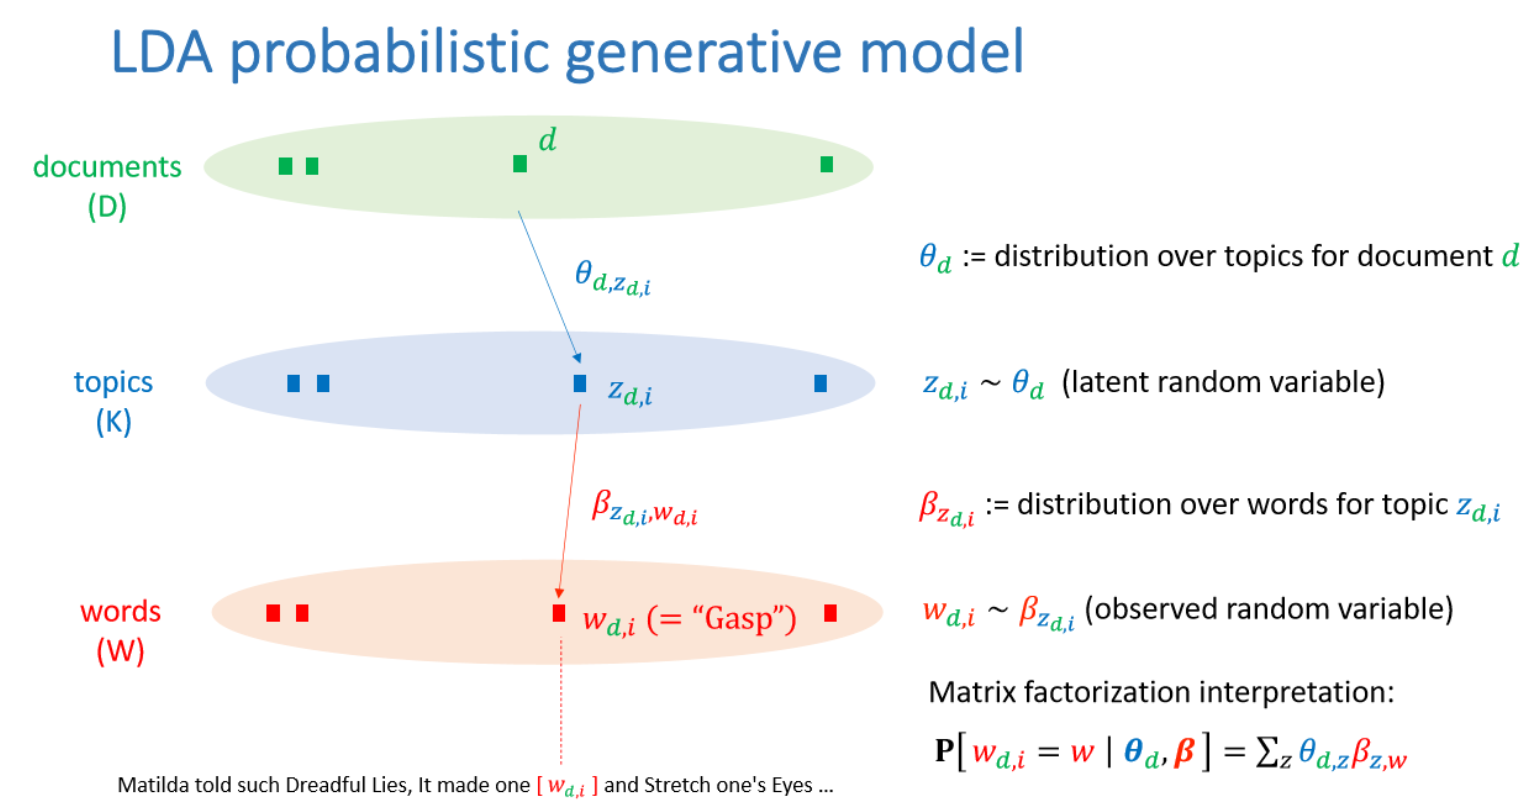

In [1]:
from IPython.display import Image
Image(filename = 'lda.png')

### Latent Dirichlet Allocation 

For topic modelling, we will use Latent Dirichlet Allocation (LDA). Proposed by Blei et al [1], LDA is a generative statistical model that allows sets of observations to be explained by latent groups that explain why some parts of the data are similar. In LDA, each document can be described by a distribution of topics and each topic can be described by a a distribution of words. Specifically, we assume that a document is associated with K topics, and that each document exhibits these topics with different proportions.

LDA is one of the most popular choices to unveal common topics as a hidden structure of the collection of documents. 
Hidden variable models are structured distributions in which observed data interact with hidden random variables. With the existence of such hidden variable model, the practitioner posits a hidden structure in the observed data, and then  learns the structure using posterior probabilistic inferenece. Hidden variable models are ubiquitous in machine learning, we have Hidden Markov Models [4], Kalman Filters [5], and mixture models [6].

In LDA, the observed data are the words of each document and the hidden variables represent the latent topic structure, i.e., the topics themselves and how each document exhibits them. Given a collection, the posterior distribution of the hidden variables given the observed ducuments determines a hidden decomposition of the collection.
The figure above presents how LDA works graphically.

Let K be a specified number of topics, V the size of the vocabulary, $\vec{a}$ a positive K-vector, and $\eta$ a scalar. We let $Dir_{V}(\vec{a})$ denote a V-dimensional Dirichlet with vector parameter $\vec{a}$ and $Dir_{K}(\eta)$ denote a K dimensional symmetric Dirichlet with scalar parameter $\eta$.

(1) For each topic, 

---(a) Draw a distribution over words $\vec{\beta_{k}}$ ~ $Dir_{V}(\eta)$.

(2) For each document, 

---(a) Draw a vector of topic proportions $\vec{\theta_{d}}$ ~ $Dir(\vec{a})$.

---(b) For each word, 

---------(i) Draw a topic assignment $Z_{d, n}$ ~ $Mult(\vec{\theta_{d}})$, $Z_{d, n}$ $\in$ {1, ..., K}.

---------(ii) Draw a word $W_{d, n}$ ~ $Mult(\vec{\beta_{z_{d, n}}})$, $W_{d, n}$ $\in$ {1, ..., V}.

LDA makes central use of the Dirichlet distribution, the exponential family distribution over the simplex of positive vectors that sum to one. The Dirichlet has density 

$p(\theta | \vec{a})$ = $\frac{\Gamma (\Sigma_{i} a_{i})}{\Pi_{i} \Gamma(a_{i})}$ $\Pi_{i}$ $\theta_{i}^{a_{i} - 1}$.

The parameter $\vec{a}$ is a positive K-vector, and $\Gamma$ denotes the Gamma function, which can be thought of as a real-valued extension of the factorial funciton.

LDA contains two Dirichlet random variables; the topic proportions $\vec{\theta}$ are distributions over topic indices 
{1, ..., K}; the topics $\vec{\beta}$ are distributions over the vocabulary.

LDA provides a joint distribution over the observed and hidden random variables. The hidden topic decomposition of a particular corpus arises from the corresponding posterior distribution of the hidden variables given the D observed documents $\vec{w_{1:D}}$,

p($\vec{\theta_{1:D}}$, $z_{1:D, 1:N}$, $\vec{\beta_{1:K}}$ | $w_{1:D, 1:N}$, $\alpha$, $\eta$) = 

$\frac{p(\vec{\theta_{1:D}}, \vec{z_{1:D}}, \vec{\beta_{1:K}} | \vec{w_{1:D}}, \alpha, \eta)}{\int_{\vec{\beta_{1:K}}} \int_{\vec{\theta_{1:D}}} \Sigma_{\vec{z}} p(\vec{\theta_{1:D}}, \vec{z_{1:D}}, \vec{\beta_{1:K}} | \vec{w_{1:D}}, \alpha, \eta)}$ 

The central computation problem for topic modelling with LDA is approximating the posterior of the above equation. 

Several approximation techniques have been developed for LDA, including mean field variational inference, collapsed variational inference, expectation propagation, and Gibbs sampling.

There are two famous optimisation algorithms for estimating the LDA model - online variational bayes and expectation- maximisation and batch  The online LDA is proposed by Hoffman, Blei and Bach in their paper "Online Learning for Latent Dirichlet Allocation" [2]; While the other is proposed by Asuncion et al. in their paper "On Smoothing and Inference for Topic Models" [3].

In [15]:
from pyspark.ml.clustering import LDA

# Here we assume the number of topics k a priori, we fix k = 4.
lda_em = LDA(k=4, maxIter=20, optimizer = "em")

# lda_online = LDA(k=4, maxIter=20, optimizer = "online")
# maxIter - Maximum number of iterations allowed. 
# optimizer - LDAOptimizer used to perform the actual calculation. Currently "em", "online" are supported. (default: "em")

# 
lda_model = lda_em.fit(df_features)

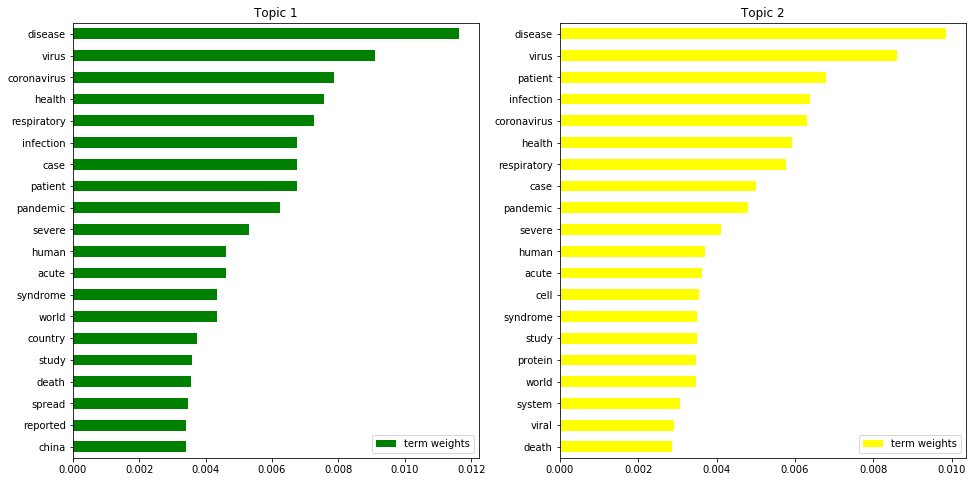

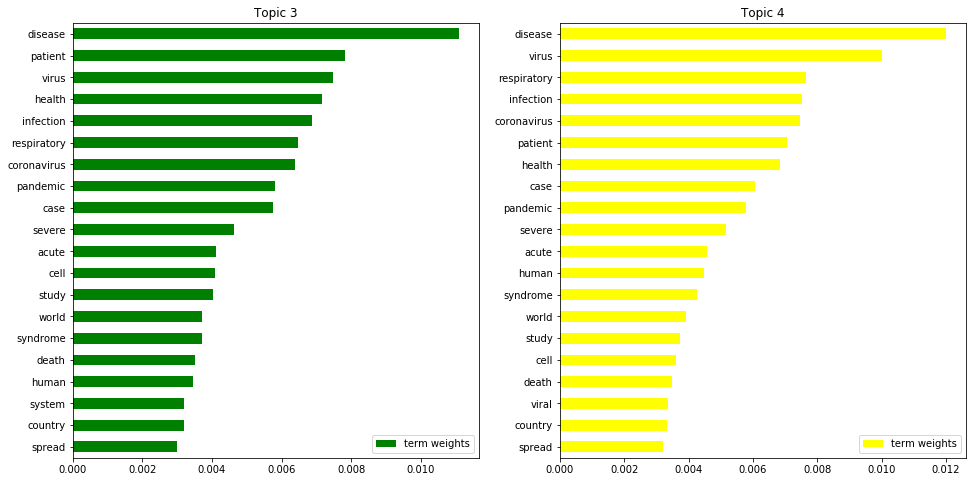

In [16]:
# Describe topics
topics = lda_model.describeTopics(20)

# print("The topics described by their top-weighted terms:")
# topics.show(truncate=True)

# Shows the results
import numpy as np
topic_i = topics.select("termIndices").rdd.map(lambda r: r[0]).collect()
topic_j = topics.select("termWeights").rdd.map(lambda r: r[0]).collect()

for i in range(len(topic_i) // 2):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))
    topic_df_1 = pd.DataFrame({'term weights': [weight for weight in topic_j[2*i]]},  index = list(np.array(df_model.vocabulary)[topic_i[2*i]]))
    topic_df_2 = pd.DataFrame({'term weights': [weight for weight in topic_j[2*i+1]]},  index = list(np.array(df_model.vocabulary)[topic_i[2*i+1]]))
    topic_df_1.sort_values('term weights').plot.barh(title = 'Topic ' + str(2*i+1), color = ['green'], ax = ax1)
    topic_df_2.sort_values('term weights').plot.barh(title = 'Topic ' + str(2*i+2), color = ['yellow'], ax = ax2)

The above chart summarises four topics with their corresponding with words sorted by the best term scores that are discovered automatically from the collection using the topic model, latent Dirichlet allocation (LDA).

### The top four topics of a 20-topic model trained on CORD-19 dataset

|topic|label|key words|
|:----|:----|:--------|
|1|Coronavirus Outbreak|China, case, reported, spread|
|2|Virus Genetics|cell, protein, system|
|3|Virus Spread / Deterioration|spread, country, world, infection|
|4|Patient Syndrome|respiratory, patient, severe, acute|

The LDA algorithm has no prior knowledge of the existence of the illustrated themes. The themes are automatically discovered from analysing the original texts. We can summarise the top four topics of the LDA model trained on CORD-19 dataset given their term weights in each topic as: coronavirus outbreak, virus genetics, virus spread/deterioation and patient syndrome.

In [17]:
# Derive topic distribution for each document 
transformed = lda_model.transform(df_features)
transformed.show(truncate=True)

+--------+--------------------+------------+--------------------+--------------------+--------------------+----+--------------------+--------------------+--------------------+
|cord_uid|               title|publish_time|                 url|            abstract|        introduction|year|               words|            features|   topicDistribution|
+--------+--------------------+------------+--------------------+--------------------+--------------------+----+--------------------+--------------------+--------------------+
|ug7v899j|Clinical features...|  2001-07-04|https://www.ncbi....|OBJECTIVE: This r...|Mycoplasma pneumo...|2001|[mycoplasma, pneu...|(76798,[4,6,14,27...|[0.24313366871818...|
|02tnwd4m|Nitric oxide: a p...|  2000-08-15|https://www.ncbi....|Inflammatory dise...|Since its discove...|2000|[discovery, biolo...|(76798,[0,4,6,7,1...|[0.19438212980958...|
|ejv2xln0|Surfactant protei...|  2000-08-25|https://www.ncbi....|Surfactant protei...|Surfactant protei...|2000|[surfact

In [18]:
# Obtain a new RDD that includes best topic assignment 
transformed_rdd = transformed.rdd.map(lambda line: (line[0], line[1], line[2], line[3], line[4], \
                                                    line[5], line[6], line[7], line[8], line[9], \
                                                    line[9].toArray().tolist().index(p.max(line[9].toArray().tolist())) + 1))
# Turn RDD into dataframe
transformed = spark.createDataFrame(transformed_rdd, ["cord_uid", "title", "publish_time", "url", "abstract", "introduction", \
                                             "year", "words", "features", "topicDistribution", "topic"])
transformed.show(10)

+--------+--------------------+------------+--------------------+--------------------+--------------------+----+--------------------+--------------------+--------------------+-----+
|cord_uid|               title|publish_time|                 url|            abstract|        introduction|year|               words|            features|   topicDistribution|topic|
+--------+--------------------+------------+--------------------+--------------------+--------------------+----+--------------------+--------------------+--------------------+-----+
|ug7v899j|Clinical features...|  2001-07-04|https://www.ncbi....|OBJECTIVE: This r...|Mycoplasma pneumo...|2001|[mycoplasma, pneu...|(76798,[4,6,14,27...|[0.24313366871818...|    4|
|02tnwd4m|Nitric oxide: a p...|  2000-08-15|https://www.ncbi....|Inflammatory dise...|Since its discove...|2000|[discovery, biolo...|(76798,[0,4,6,7,1...|[0.19438212980958...|    3|
|ejv2xln0|Surfactant protei...|  2000-08-25|https://www.ncbi....|Surfactant protei...|Surf

### Number of Documents by Dominant Topic

Here we define dominant topic for each ducument by the topic with the largest probability.

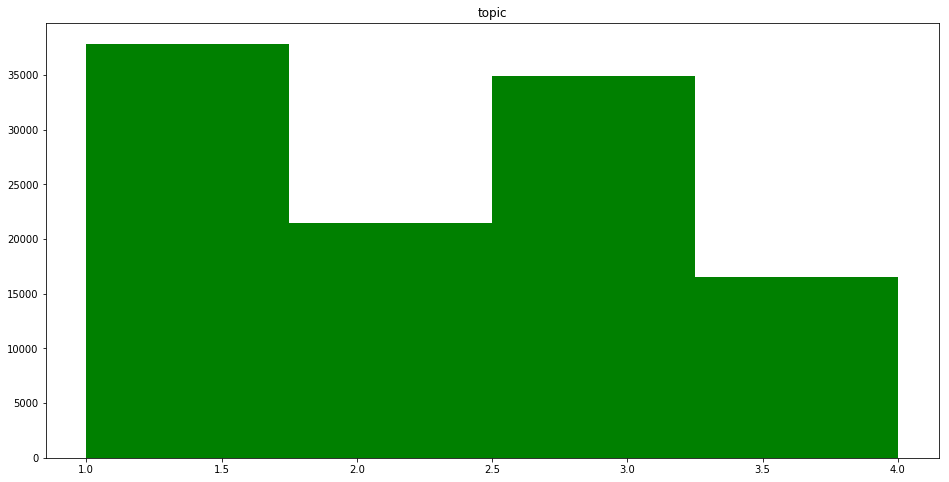

In [19]:
hist = transformed.select('topic').toPandas().hist(bins=4, grid = False, figsize = (16, 8), color = 'green')

From the histogram shown above, we can find that topic one (coronavirus outbreak) is the dominant topic in the CORD-19 dataset, following by topic three (virus spread / deterioration) and topic two (virus genetics). Topic four (patient syndrome) is the least dominant topic.

### Evolution of topics from 2016 - 2021

Another interesting question is at what time topics appear or disappear and how the words representing a topic change over time.

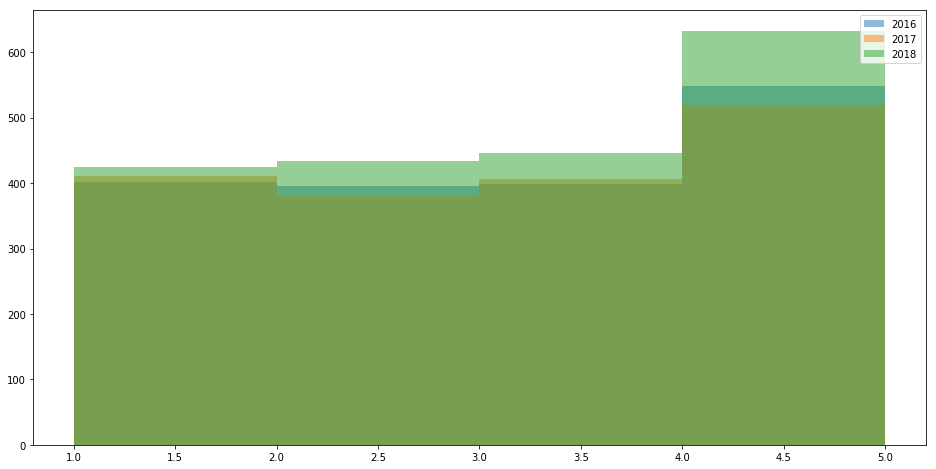

In [25]:
topic_year = transformed.select('topic', 'year').toPandas().sort_values('year').dropna()

index_year_ls = []
for i in range(len(topic_year)):
    try:
        if float(topic_year.iloc[i, 1]) >= 2000 and len(topic_year.iloc[i, 1]) == 4:
            index_year_ls.append(i)
    except ValueError:
        continue
        
topic_year = topic_year.iloc[index_year_ls,:]

a = topic_year[topic_year.year == '2016'].topic.tolist()
b = topic_year[topic_year.year == '2017'].topic.tolist()
c = topic_year[topic_year.year == '2018'].topic.tolist()

bins = [1, 2, 3, 4, 5]

plt.figure(figsize=(16,8))
pyplot.hist(a, bins, alpha=0.5, label='2016')
pyplot.hist(b, bins, alpha=0.5, label='2017')
pyplot.hist(c, bins, alpha=0.5, label='2018')
pyplot.legend(loc='upper right')
pyplot.show()

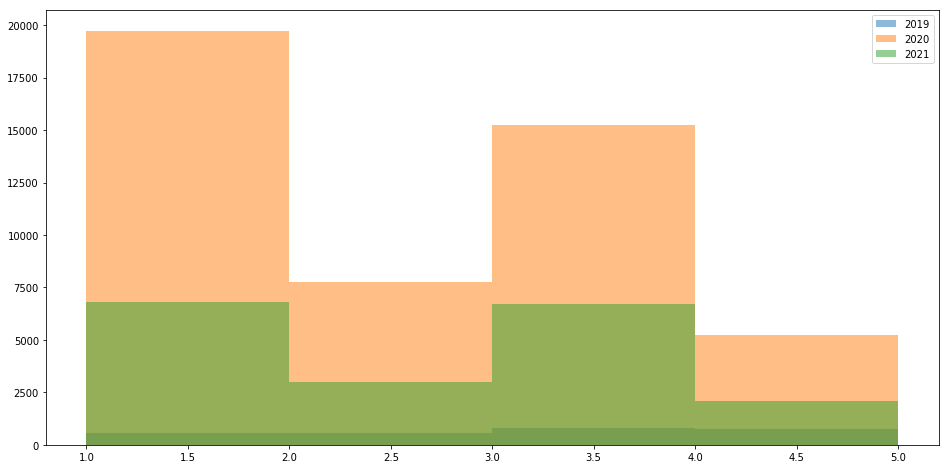

In [27]:
a = topic_year[topic_year.year == '2019'].topic.tolist()
b = topic_year[topic_year.year == '2020'].topic.tolist()
c = topic_year[topic_year.year == '2021'].topic.tolist()

bins = [1, 2, 3, 4, 5]

plt.figure(figsize=(16,8))
pyplot.hist(a, bins, alpha=0.5, label='2019')
pyplot.hist(b, bins, alpha=0.5, label='2020')
pyplot.hist(c, bins, alpha=0.5, label='2021')
pyplot.legend(loc='upper right')
pyplot.show()

From the histograms shown above, which indicate the evolution of the topics from 2016 - 2021, we found that topic four (patient syndrome) is the most dominant topic between 2016 - 2019. However, since the outbreak of Covid-19 pandemic, we found that topic one (coronavirus outbreak) and topic three (virus spread / deterioration) start to take the lead, which indeed makes logical sense.

In [22]:
# Make a copy of transformed dataframe
transformed_copy = transformed

-------------------------
## Paper Recommendation

We cluster research papers based on their Jensen-Shannon distance in the topic space. So what is Jensen-Shannon Distance?

### Jensen-Shannon Distance

> In probability theory and statistics, the Jensen–Shannon divergence is a method of measuring the similarity between two probability distributions. It is based on the Kullback–Leibler divergence, with some notable (and useful) differences, including that it is symmetric and it always has a finite value. The square root of the Jensen–Shannon divergence is a metric often referred to as Jensen-Shannon distance. 
[Wikipedia](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence)

**Jensen-Shannon Distance** = $\sqrt{Jensen-Shannon Divergence}$

In [29]:
def recommendation(UID, df, is_covid = False, is_only_covid_19_and_relevant_time = False, lower = None, upper = None, plot=False):
    """
    Recommends the top 5 research articles based on Jensen-Shannon Distance in topic space
    Plots the topic distribution comparison between the paper we pick and the recommended paper. 
    param:
    UID: paper uid numebr
    lower: lower bound of the date
    upper: upper bound of the date
    """
    if is_covid:
        df = only_covid_19_and_relevant_time(df)
            
    if is_only_covid_19_and_relevant_time:
        df = only_covid_19_and_relevant_time(df, lower, upper)
        
        
    df_1 = broadcast(df.filter(df.cord_uid == UID).select('title', 'topicDistribution')).\
                 crossJoin(df.select('url', 'title', 'topicDistribution').\
                           withColumnRenamed('title', 'title_1').\
                           withColumnRenamed('topicDistribution','topicDistribution_1'))
    
    df_2 = df_1.filter(df_1.title != df_1.title_1)
    df_3 = df_2.filter((df_2.title != df_2.title_1) \
                                     & (df_2.title_1 != df_2.title))
    
    df_4 = df_3.rdd.map(tuple)
    similarity_rdd = df_4.map(lambda x: (x[0], x[1], x[2], x[3], x[4], 1 - float(np.sqrt(float(jensenshannon(x[1],x[4]))))))
    similarity_df = similarity_rdd.toDF().withColumnRenamed('_1', 'title').\
                                          withColumnRenamed('_2', 'topic distribution').\
                                          withColumnRenamed('_3', 'url').\
                                          withColumnRenamed('_4', 'recommended title').\
                                          withColumnRenamed('_5', 'recommended topic distribution').\
                                          withColumnRenamed('_6', 'similarity').sort("similarity", ascending = False)
    
    pandas_df = similarity_df.filter(similarity_df.similarity != float('nan')).select('title', 'topic distribution', 'url', 'recommended title', 'recommended topic distribution', 'similarity').toPandas()

    print('Papers similar to "' + pandas_df['title'][0] + '" between ' + str(lower) + ' and' + str(upper) + ' are: ')
    print('\n')
    
    h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' + ' (Similarity: ' + "{:.2f}".format(s) + ')' for l, n, s in pandas_df[:5][['url','recommended title', 'similarity']].values])
    display(HTML(h))
    
    if plot:
        compare_tabs(pandas_df[:5], pandas_df[:5]['recommended title'].values)

In [30]:
def compare_dnas(df, title, width=20):
    t = title
    temp = pd.DataFrame([list(df['topic distribution'])])
    ymax = temp.max(axis=1).values[0]*1.25
    temp = pd.concat([temp, pd.DataFrame([list(df['recommended topic distribution'])])])
    temp.T.plot(kind='bar', title=t, figsize=(width, 4), ylim= [0, ymax])
    plt.xlabel('Topic')
    plt.legend(['Selection', 'Recommendation'])
    
    
def compare_tabs(df, title):
    k = len(df)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            ax = compare_dnas(df.loc[i], title[i])
            plt.show(ax)

### What are the top 5 most relevant COVID-19 papers to the paper with uid 'yv4x8viu' between 2020 and 2021? 

In [31]:
recommendation('yv4x8viu', transformed, is_covid = False, is_only_covid_19_and_relevant_time = True, lower = 2020, upper = 2021, plot=True)

Papers similar to "Extracorporeal Life Support Organization Coronavirus Disease 2019 Interim Guidelines: A Consensus Document from an International Group of Interdisciplinary Extracorporeal Membrane Oxygenation Providers" between 2020 and2021 are: 




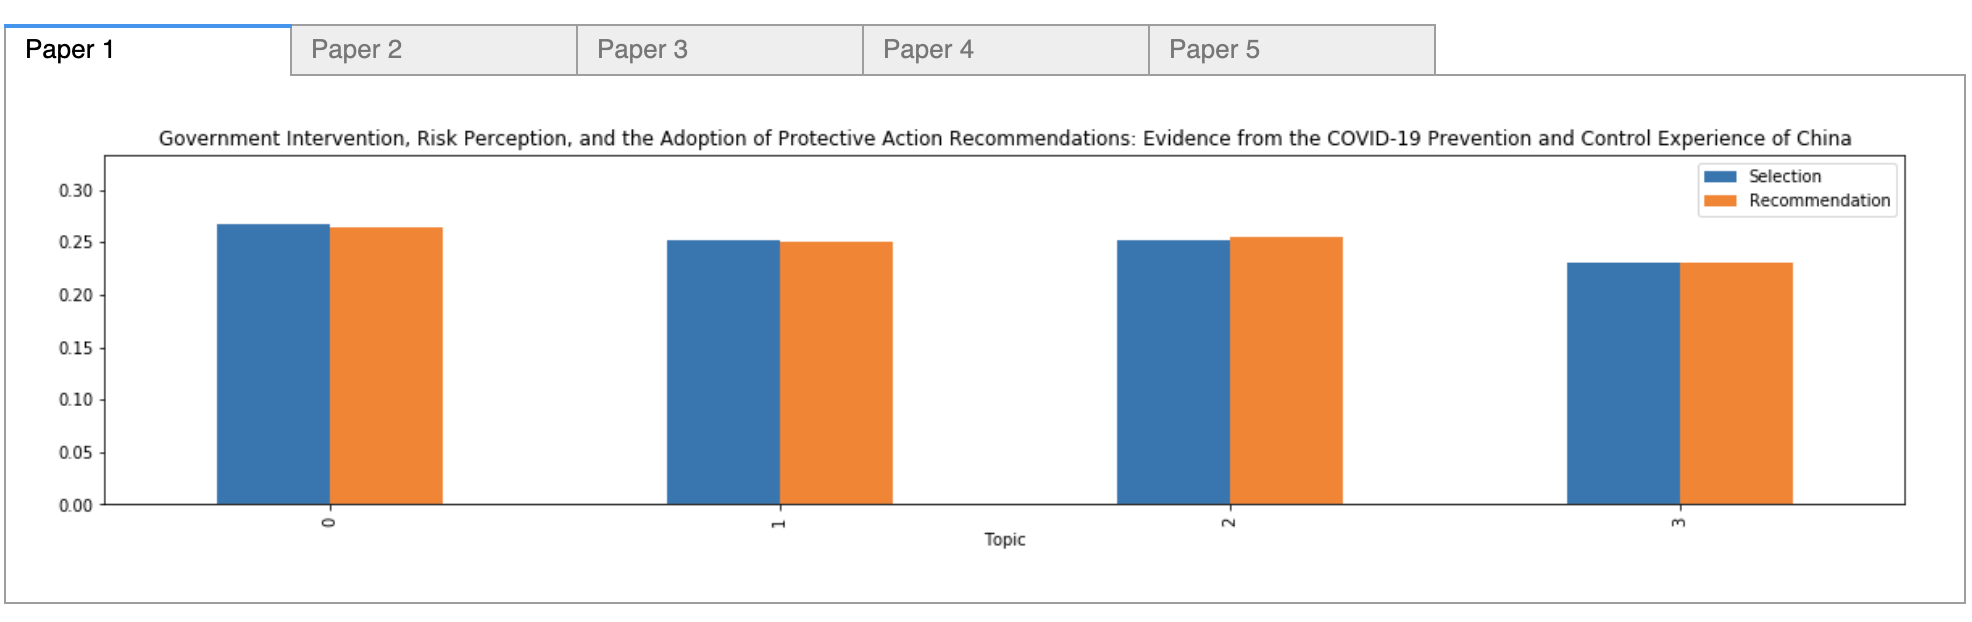

In [6]:
Image(filename = 'widget_0.png')

----------------------------
## Interactive Widgets 

We can enter a task into the recommendation engine that firstly convert it into a vector in the topic space, then find related articles by similarity measure.

In [32]:
def relevant_papers(df, tasks, k = 3, lower = 2000, upper = 2021, topic_num = None, find_covid19 = False, find_relevant_time = False, find_specific_topic = False):
    """
    Finds relevant papers given specific tasks or text.
    param
    k: number of recommended papers
    lower: lower bound of the date
    upper: upper bound of the date
    topic_num: topic number that we are interested in
    """
    tasks = [tasks] if type(tasks) is str else tasks
    
    tasks_rdd = sc.parallelize(tasks)
    tasks_rdd = tasks_rdd.map(lambda l: (l, get_tokens(l)))
    task_df = tasks_rdd.toDF().withColumnRenamed('_1', 'task').withColumnRenamed('_2', 'words')
    task_df_features = df_model.transform(task_df)
    # Shows the result
    task_transformed = lda_model.transform(task_df_features)
    
    if find_covid19:
        df = only_covid_19(df)
            
    if find_relevant_time:
        df = relevant_time(df, lower, upper)
            
    if find_specific_topic:
        df = specific_topic(df, topic_num)

    for task in tasks:
                    
        df_1 = broadcast(task_transformed.filter(task_transformed.task == task).select('task', 'topicDistribution')).\
                 crossJoin(df.select('url', 'title', 'topicDistribution').\
                           withColumnRenamed('topicDistribution','topicDistribution_1'))

        df_2 = df_1.rdd.map(tuple)
        similarity_rdd = df_2.map(lambda x: (x[0], x[1], x[2], x[3], x[4], 1 - float(np.sqrt(float(jensenshannon(x[1],x[4]))))))
        similarity_df = similarity_rdd.toDF().withColumnRenamed('_1', 'task').\
                                              withColumnRenamed('_2', 'topic distribution').\
                                              withColumnRenamed('_3', 'url').\
                                              withColumnRenamed('_4', 'recommended title').\
                                              withColumnRenamed('_5', 'recommended topic distribution').\
                                              withColumnRenamed('_6', 'similarity').sort("similarity", ascending = False)
    
        pandas_df = similarity_df.filter(similarity_df.similarity != float('nan')).select('topic distribution', 'url', 'recommended title', 'recommended topic distribution', 'similarity').toPandas()
        
        print('Task: ' + task)
        h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' + ' (Similarity: ' + "{:.2f}".format(s) + ')' for l, n, s in pandas_df[:k][['url','recommended title', 'similarity']].values])
        display(HTML(h))
        print('\n')

In [33]:
def search_papers_for_task(df):
    
    def main_function(bullet, task, k=5, year_range=[2000, 2021], topic_range = 4, only_covid19=False):
        relevant_papers(df, [bullet], k, lower = year_range[0], upper = year_range[1], topic_num = topic_range, \
                        find_covid19 = only_covid19, find_relevant_time = True, find_specific_topic = True)
        bulletW.options = tasks[task]    

    yearW = widgets.IntRangeSlider(min=2000, max=2021, value=[2000, 2021], description='Year Range', 
                                   continuous_update=False, layout=Layout(width='25%'))
    topicW = widgets.IntSlider(min=1, max=4, value= 3, description='Topic', 
                                   continuous_update=False, layout=Layout(width='25%'))
    covidW = widgets.Checkbox(value=True,description='Only COVID-19 Papers',disabled=False, indent=False, layout=Layout(width='20%'))
    kWidget = widgets.IntSlider(value=5, description='k', max=10, min=1, layout=Layout(width='30%'))

    taskW = widgets.Dropdown(options=tasks.keys(), layout=Layout(width='90%', height='50px'), description='Task:')
    init = taskW.value
    bulletW = widgets.Select(options=tasks[init], layout=Layout(width='90%', height='200px'), description='Bullet Point:')

    widget = widgets.interactive(main_function, task=taskW, bullet=bulletW, k=kWidget, year_range=yearW, topic_range = topicW, only_covid19=covidW)
    
    controls = VBox([HBox([widget.children[2], widget.children[3], widget.children[4], widget.children[5]], layout=Layout(width='100%', justify_content='space-around')),
                     widget.children[1],
                     widget.children[0]], layout=Layout(align_items='center'))
    
    output = widget.children[-1]
    display(VBox([controls, output]))

In [34]:
task_notebooks = ['How much we know about non-pharmaceutical interventions?',
                  'How much we know about the vaccines and therapeutics?',
                  'What are the COVID-19 risk factors?',
                  'How much we know about virus genetics, origin, and evolution?',
                  'What has been published about transimission, incubation, and environmental stability?']
                  

task1 = ["Methods to control the spread in communities, barriers to compliance and how these vary among different populations.",
         "Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments.",
         "Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches."]

task2 = ["Exploration of use of best animal models and their predictive value for a human vaccine.", 
         "Efforts targeted at a universal coronavirus vaccine.", 
         "Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents."]

task3 = ['Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups', 
        'Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.',
        'Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors'] 

task4 = ['Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.',
         'Animal host(s) and any evidence of continued spill-over to humans',
         'Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.']

task5 = ['Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).',
        'Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings',
        'Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings']

tasks={task_notebooks[0]: task1, \
       task_notebooks[1]: task2, \
       task_notebooks[2]: task3, \
       task_notebooks[3]: task4, \
       task_notebooks[4]: task5}

### What if we have specific tasks in mind and we want to find research articles that are similar to each task?

We could of course do more than just finding research articles similar to the paper title or uid that we specify. In real life, especially for front line health professionals, they are likely to have a question or task in mind when they search for research papers. Can we provide a recommendation regime with a tailored solution for them? The answer is yes. Below are some of the tasks health professionals or researchers in COVID-19 pandemic might be interested in.


1. How much we know about non-pharmaceutical interventions?

2. How much we know about the vaccines and therapeutics?

3. What are the COVID-19 risk factors?

4. How much we know about virus genetics, origin, and evolution?'
                  
5. What has been published about transimission, incubation, and environmental stability?

#### Note: Since our work is performed in PySpark platform and the widgets can not be displayed in the downloaded Jupyter Notebook, we instead display the screenshots for the outputs of each task. 

#### Task: How much we know about non-pharmaceutical interventions?

In [35]:
search_papers_for_task(transformed)

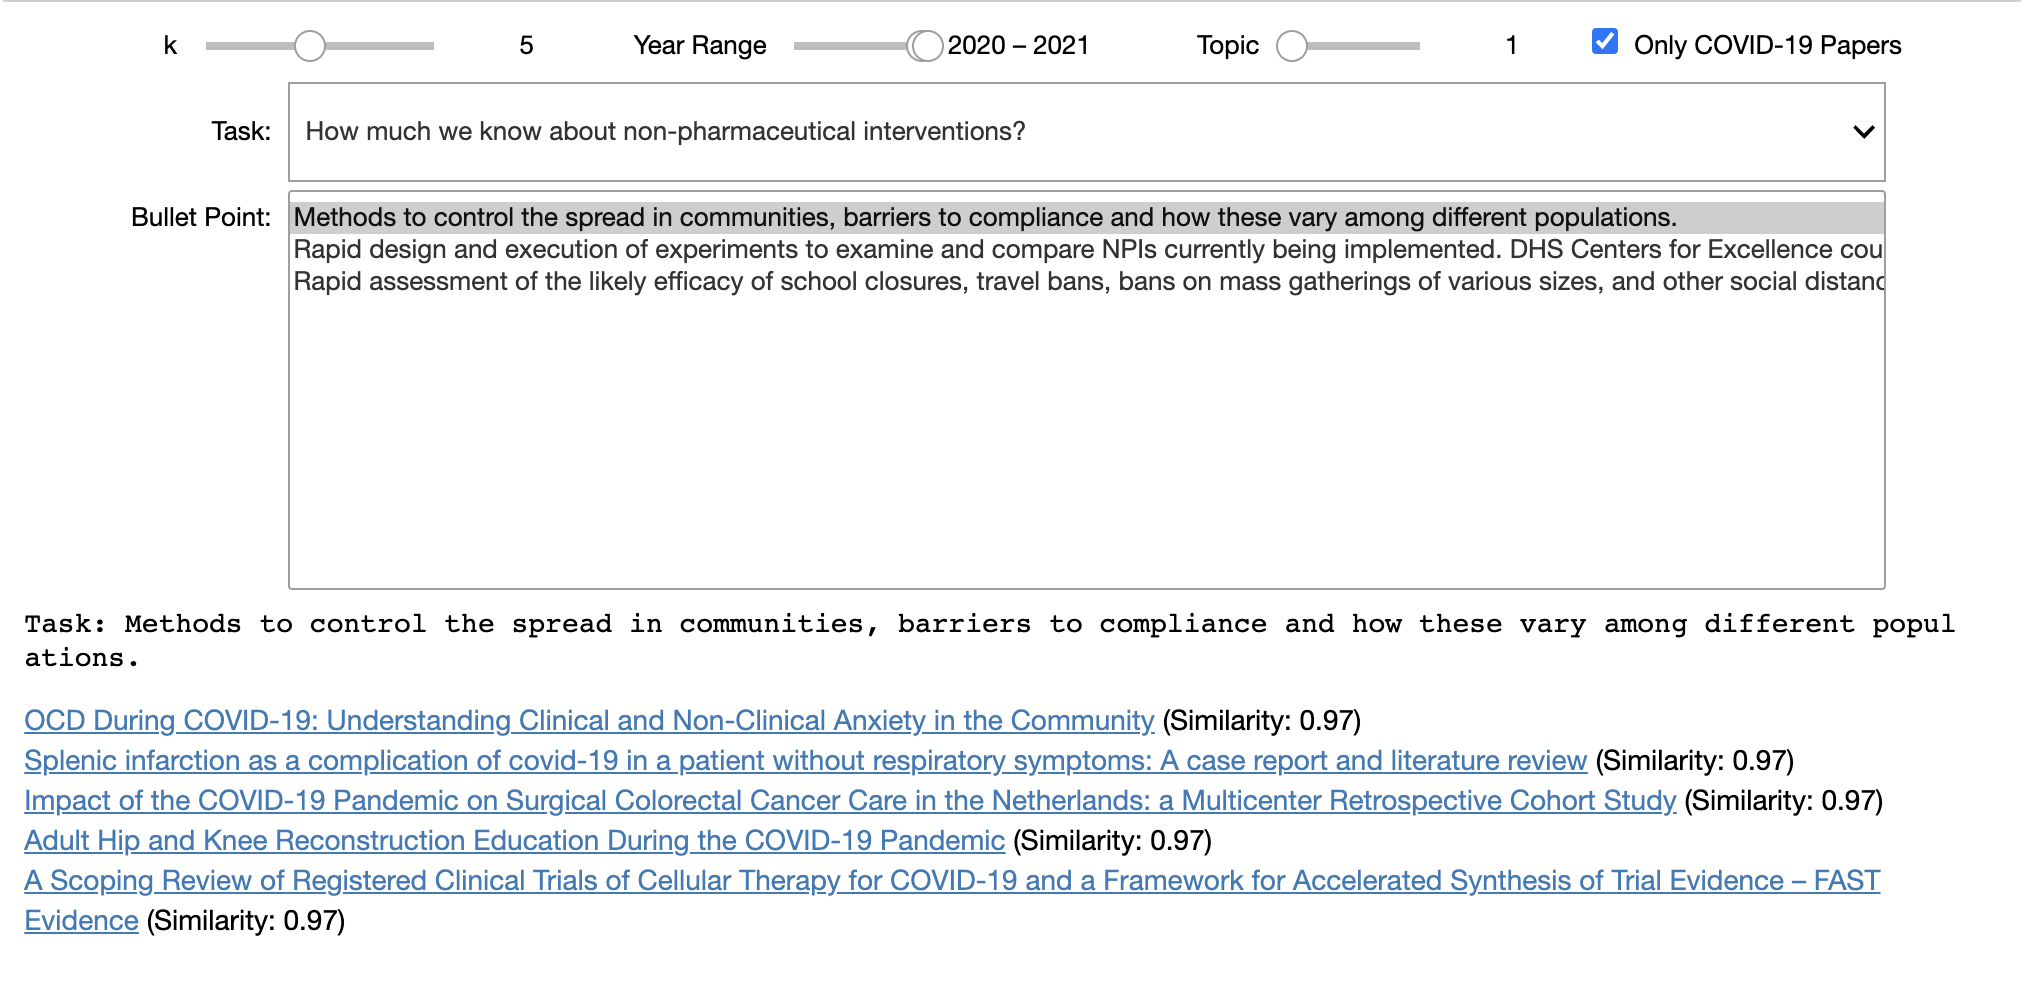

In [2]:
Image(filename = 'widget_1.png')

#### Task: How much we know about the vaccines and therapeutics?

In [36]:
search_papers_for_task(transformed)

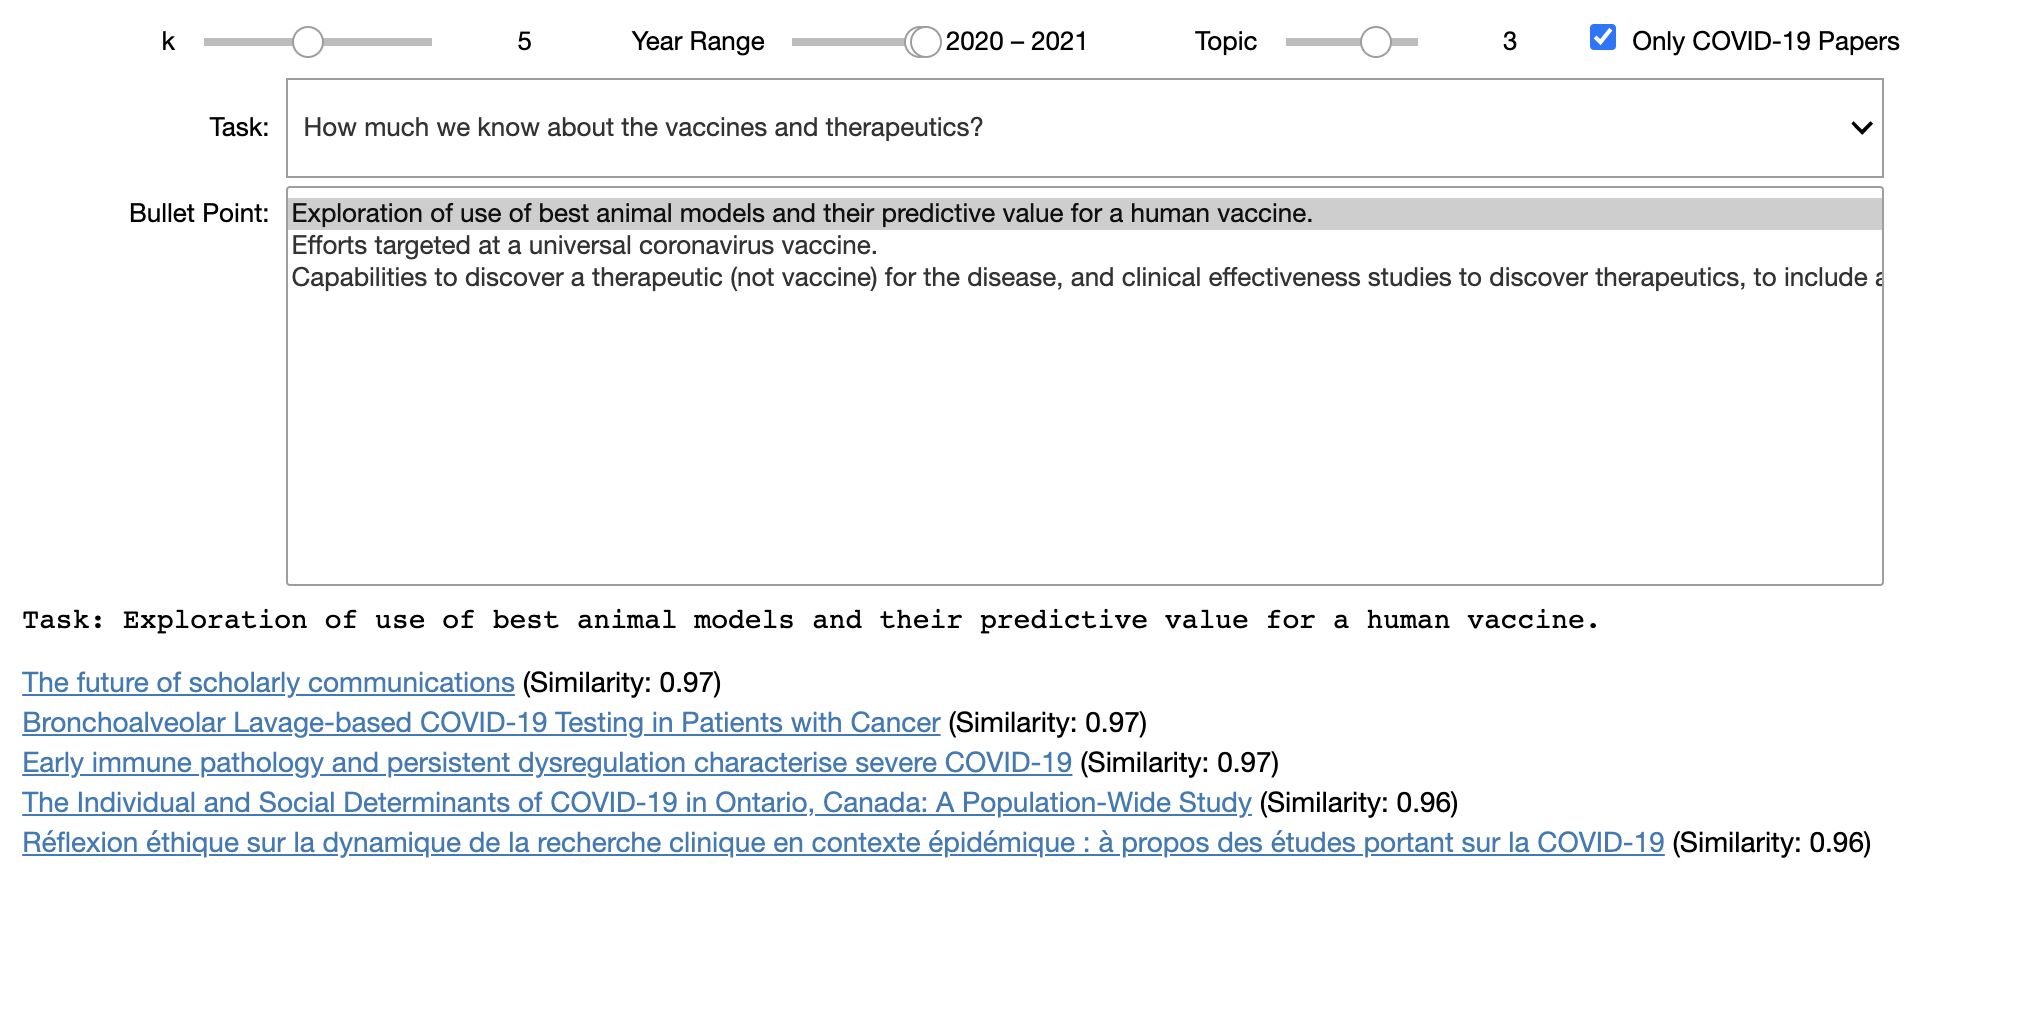

In [3]:
Image(filename = 'widget_2.png')

#### Task:  What are the COVID-19 risk factors?

In [38]:
search_papers_for_task(transformed)

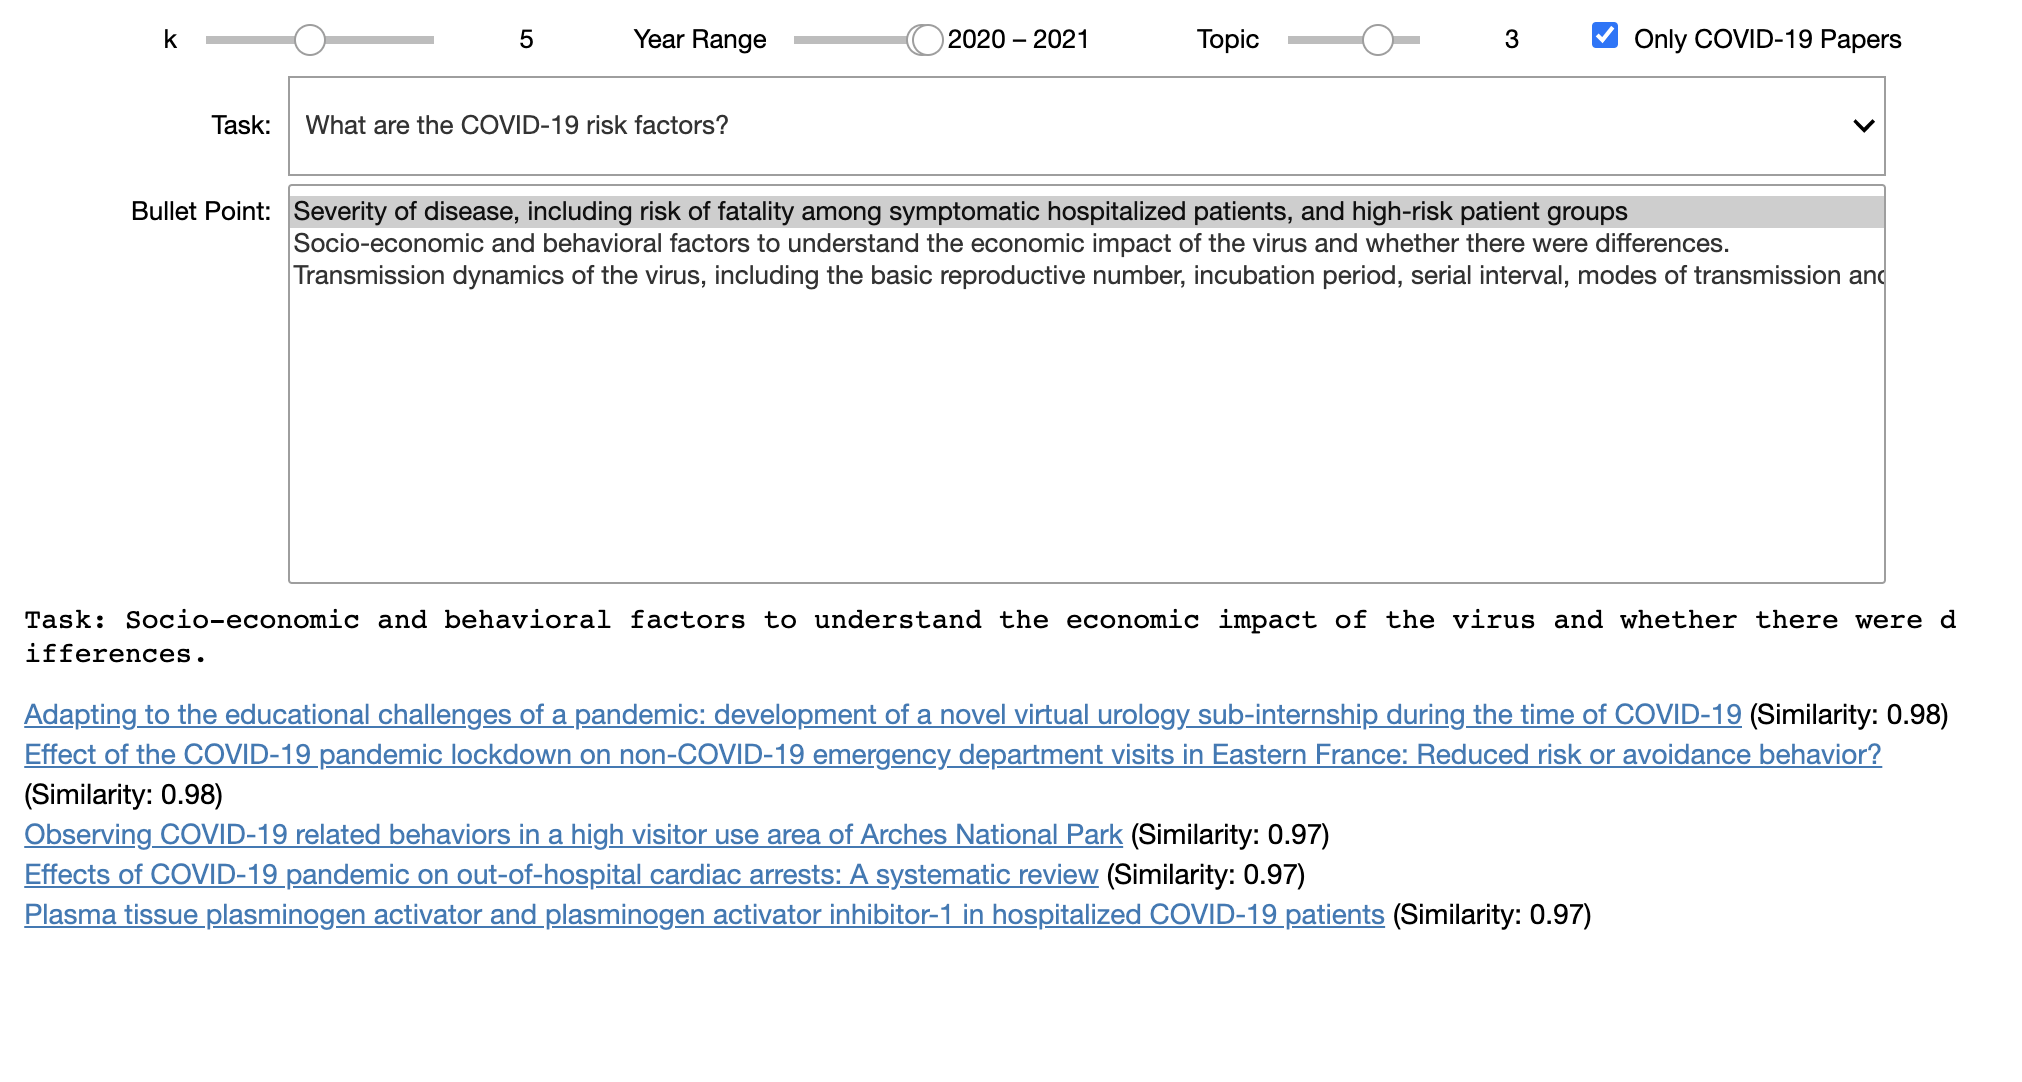

In [4]:
Image(filename = 'widget_3.png')

#### Task: How much we know about virus genetics, origin, and evolution?'

In [ ]:
search_papers_for_task(transformed)

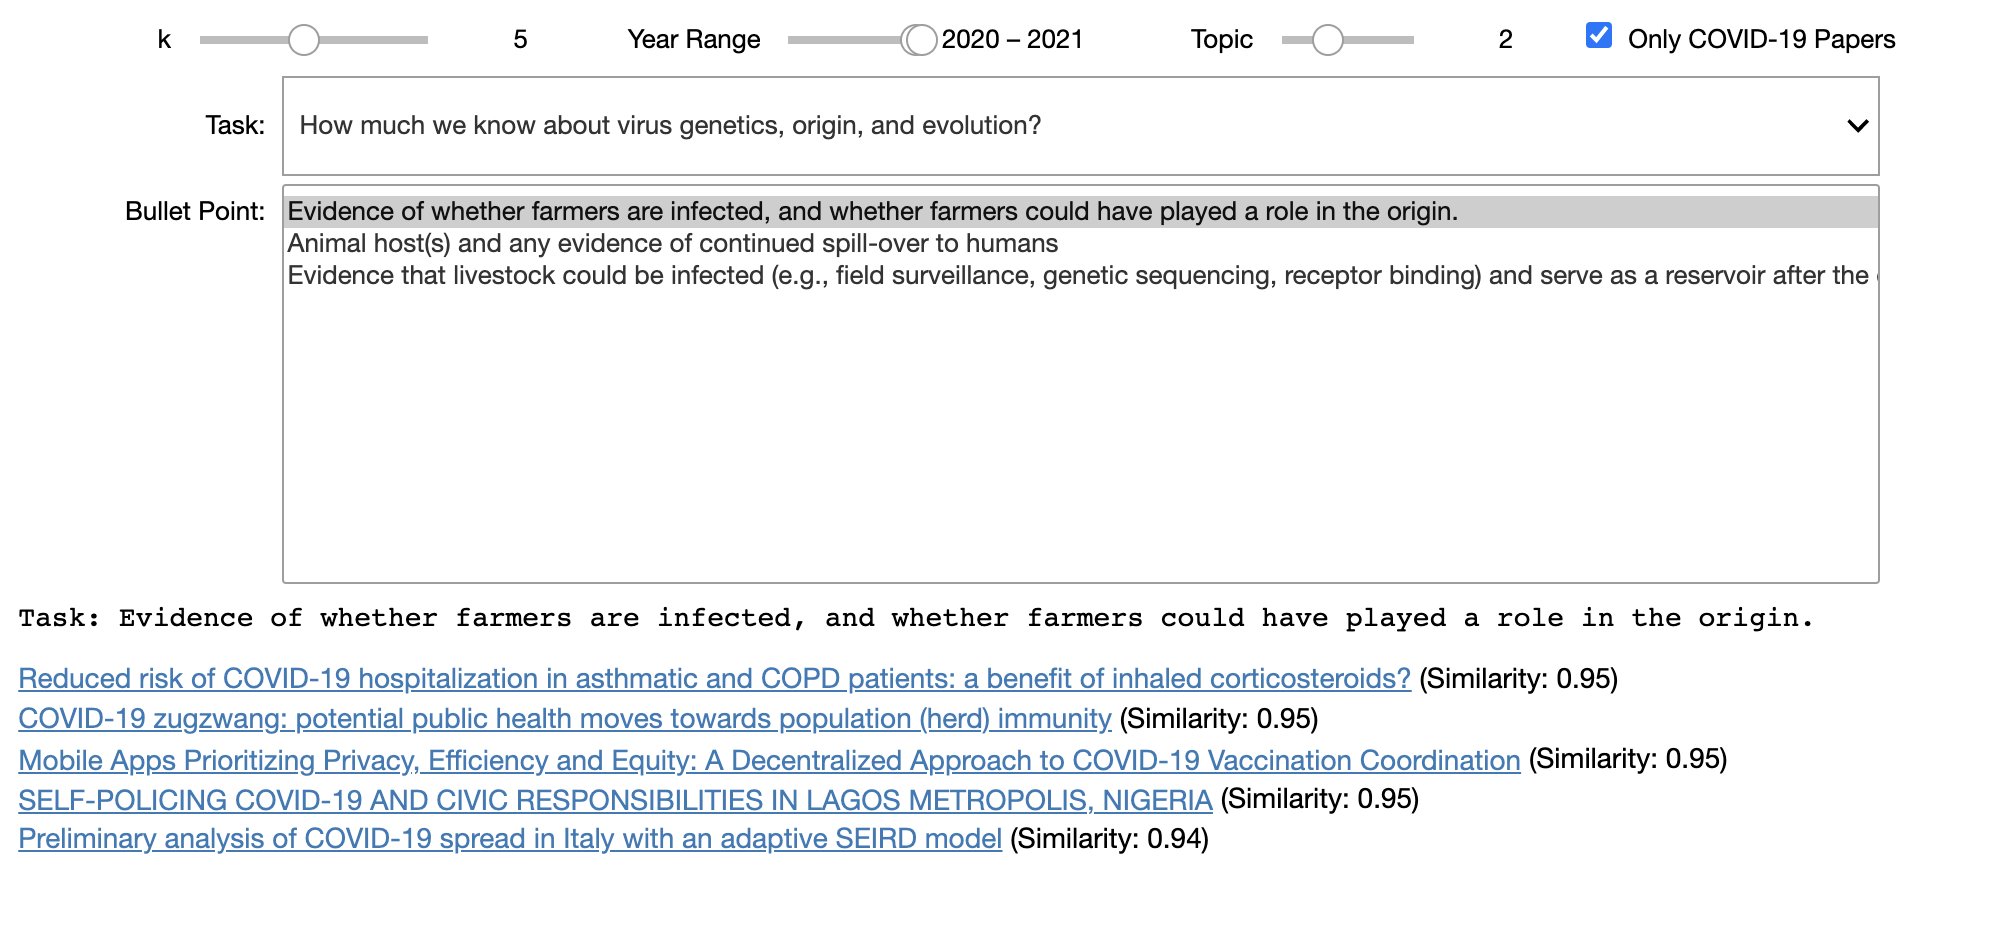

In [7]:
Image(filename = 'widget_5.png')

#### Task: What has been published about transimission, incubation, and environmental stability?

In [ ]:
search_papers_for_task(transformed)

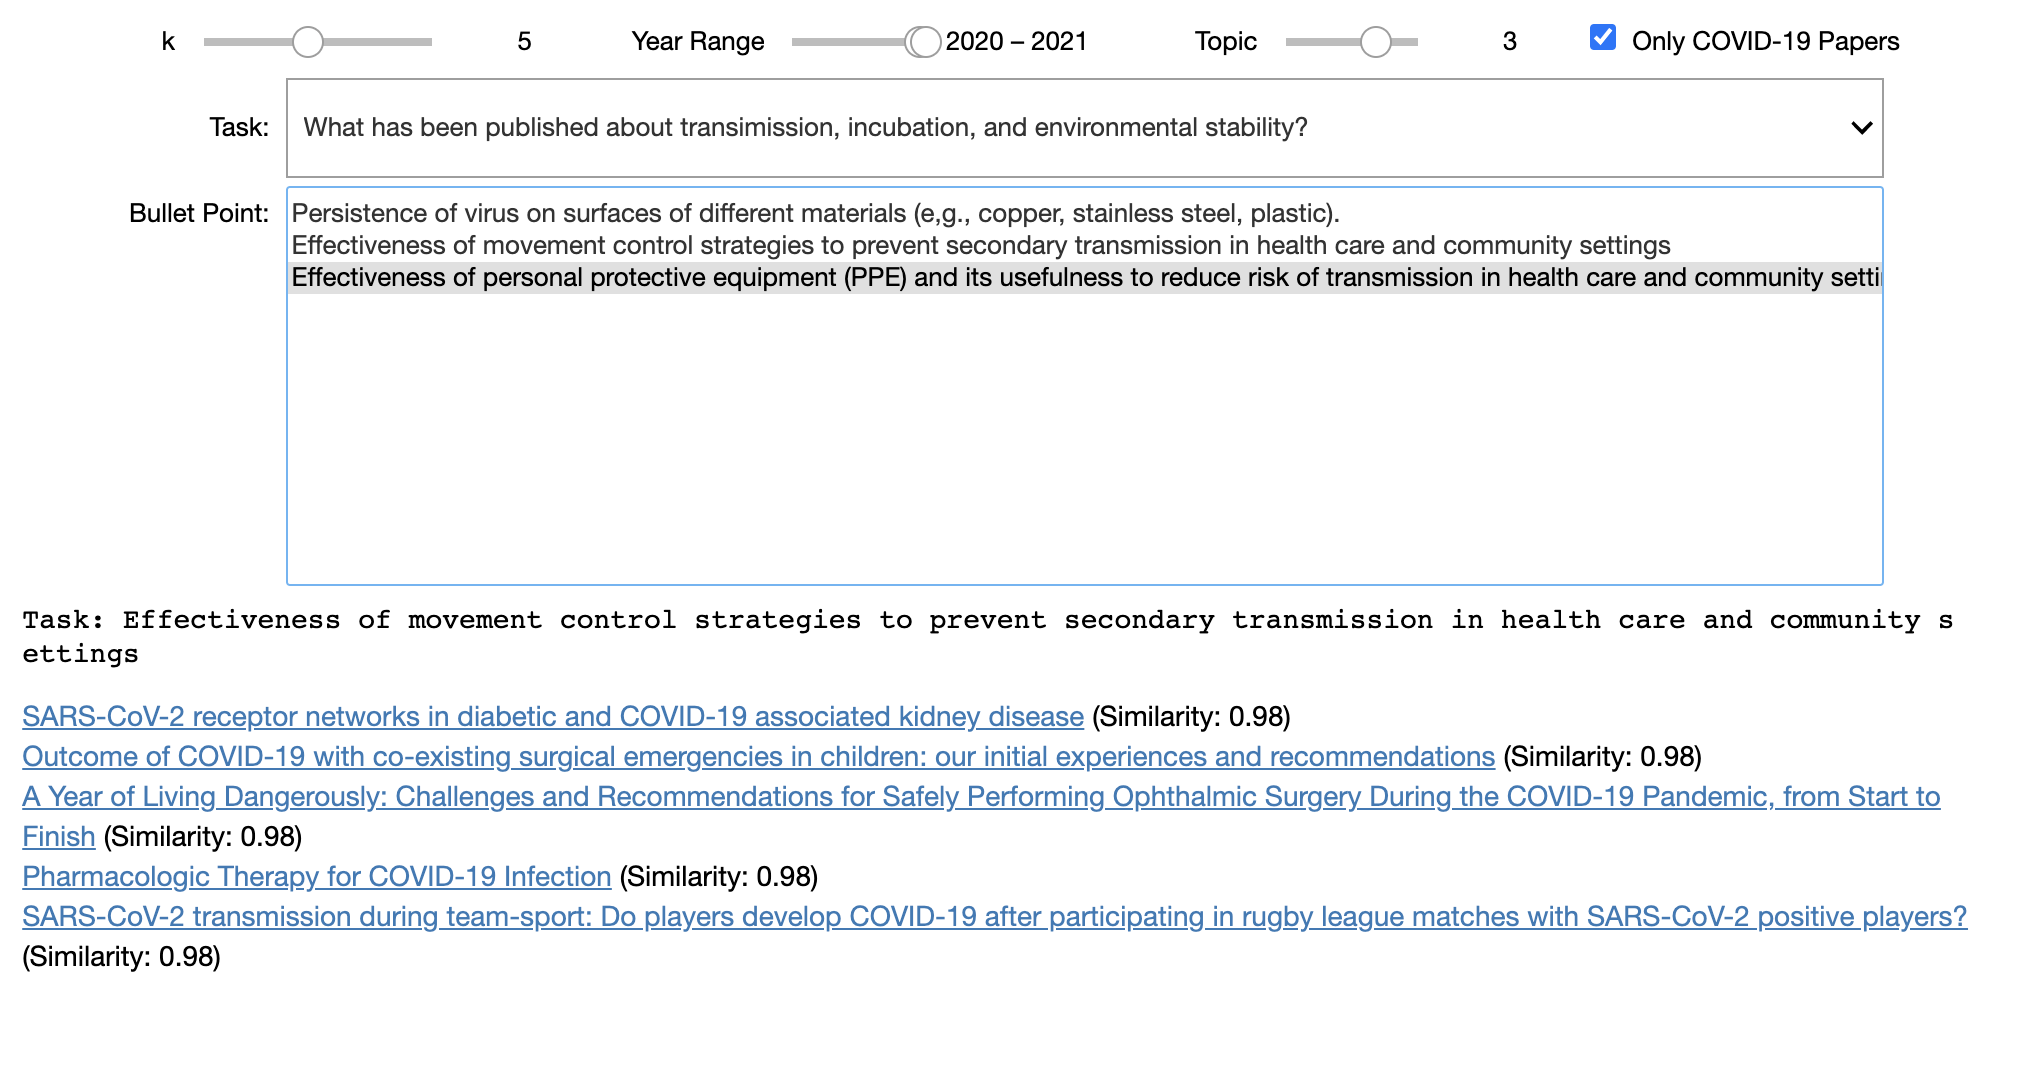

In [8]:
Image(filename = 'widget_6.png')

### What if we read an article online and we want to quickly find research papers that are similar to the article?

The answer is simiple, just simply paste the text to the type window, and the recommendation engime would do the rest.

We can insert all kind of text (articles, research questions in mind, abstract from other papers and bulletpoints, etc) into the recommendation engine that firstly convert it into a sparse vector in the topic space, then find related articles by similarity measure.

In [39]:
def search_papers_for_text(df):    
    textW = widgets.Textarea(
        value='',
        placeholder='Type something',
        description='',
        disabled=False,
        layout=Layout(width='90%', height='200px')
    )

    yearW = widgets.IntRangeSlider(min=2000, max=2021, value=[2010, 2021], description='Year Range', 
                               continuous_update=False, layout=Layout(width='30%'))
    topicW = widgets.IntSlider(min=1, max=4, value= 3, description='Topic', 
                                   continuous_update=False, layout=Layout(width='30%'))
    covidW = widgets.Checkbox(value=True,description='Only COVID-19-Papers',disabled=False, indent=False, layout=Layout(width='20%'))
    
    kWidget = widgets.IntSlider(value=5, description='k', max=10, min=1, layout=Layout(width='20%'))

    button = widgets.Button(description="Search")

    display(VBox([HBox([kWidget, yearW, topicW, covidW], layout=Layout(width='100%', justify_content='space-around')),
        textW, button], layout=Layout(align_items='center')))

    def on_button_clicked(b):
        clear_output()
        display(VBox([HBox([kWidget, yearW, topicW, covidW], layout=Layout(width='90%', justify_content='space-around')),
            textW, button], layout=Layout(align_items='center')))        
        relevant_papers(df, tasks = textW.value, k = kWidget.value, lower = yearW.value[0], upper = yearW.value[1], 
                        topic_num = topicW.value, find_covid19 = covidW.value, find_relevant_time = True,
                        find_specific_topic = True)

    button.on_click(on_button_clicked)

#### News Article: Do masks reduce COVID-19 severity?

News link: https://www.medicalnewstoday.com/articles/why-might-face-masks-reduce-covid-19-severity#Do-masks-reduce-COVID-19-severity?

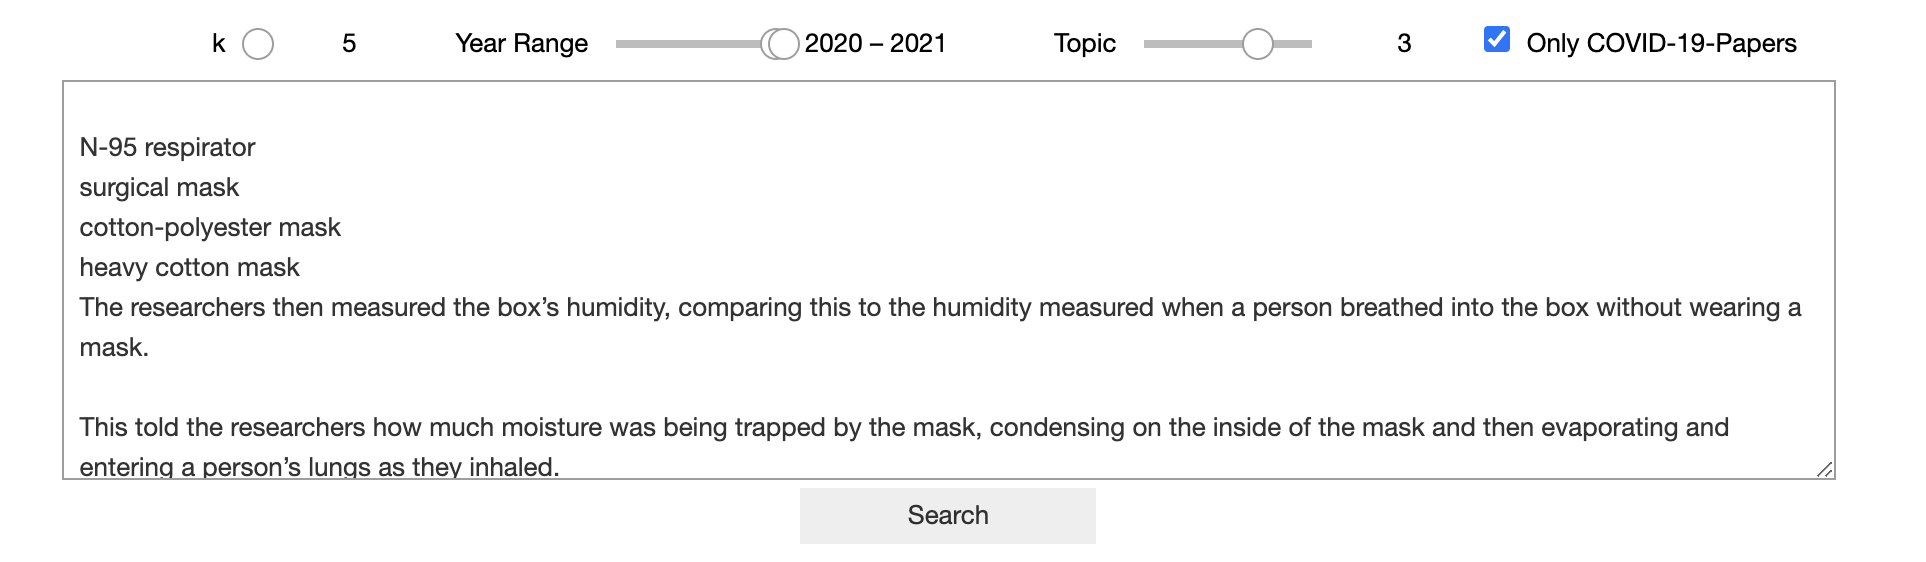

In [5]:
Image(filename = 'widget_4.png')

In [40]:
search_papers_for_text(transformed)

Task: Do masks reduce COVID-19 severity?
Face masks have been a crucial non-pharmaceutical intervention in the COVID-19 pandemic. Researchers believe they reduce the chances of a person passing the virus to another person, as well as acquiring the virus themselves.

Further, while healthcare professionals continue administering effective vaccines around the world, mask-wearing is still necessary.

The Centers for Disease Control and Prevention (CDC) point out there is not yet enough information on how these vaccines work in the real-world to recommend people stop wearing masks, even for those who have received two doses of the vaccines.

Recent research, which appears in the Journal of General Internal Medicine and the New England Journal of Medicine, found that face masks effectively reduce SARS-CoV-2 transmission and may also reduce its severity.

The researchers behind the articles suggest this is due to mask-wearers likely having exposure to reduced amounts of the virus. However, o

---------------------------------
## Conclusion

In this project, we have attempted to cluster published literature on COVID-19. The main contribution of this research project is threefold. First, we apply the topic modelling algorithm in clustering similar rearch papers in CORD-19 dataset. We identify four topic themes given the words sorted by term weights in their corresponding topic. We also present the evolution of the dominant topic from 2016 - 2021. Moreover, we build recommendation engines that could find researh papers similar to the task we have in mind or the text we find somewhere else. Grouping the literature in this way allows health professionals to quickly identify material related to a topic of interest from a certain timeframe. Last but not least, all of our work in this project is performed in PySpark with the aim of accelerating the speeed of large-scale processing. A future improvement is to investigate the coputational efficiency gain in PySpark platfrom in comparison to the one without distributed data processsing.


-----------------------
## Reference

[1] "Latent Dirichlet Allocation" https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf?TB_iframe=true&width=370.8&height=658.8

[2] "Online Learning for Latent Dirichlet Allocation" https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.984.3103&rep=rep1&type=pdf

[3] "On Smoothing and Inference for Topic Models" https://arxiv.org/pdf/1205.2662.pdf;On

[4] "Hidden Markov Models for Speech Recognition" https://www.jstor.org/stable/pdf/1268779.pdf?casa_token=FUcgYrmBi78AAAAA:zdJEx57WVCBfvAL7qMBGOJw9szLBEKWOETA_SD-iIc1xmrQX3HF0xnOFlE9OSneEPgsX0kSQHi1HLbQKu6B0FQ7Kuy4Jbea_Th3hCpo88v73CbUN44Y

[5] "Kalman filters" http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.348.6334&rep=rep1&type=pdf

[6] "Mixture models: Inference and applications to clustering" https://www.jstor.org/stable/2289892?origin=crossref&seq=1#metadata_info_tab_contents